In [1]:
from matplotlib import cm
import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def data_import(path, delimiter):
    # Read the data, treating empty strings as NaN
    if delimiter == 'none':
        data = pd.read_csv(path, na_values=["", " ", "nan", "NaN", "NA"])
    else:
        data = pd.read_csv(path, delimiter=delimiter, na_values=["", " ", "nan", "NaN", "NA"])
    
    # Drop rows with any NaN values
    data.dropna(axis=0, how='any', inplace=True)
    return data



def data_frequency(file1, desired_frequency: str):
    # Ensure 'Time(UTC)' is in datetime format
    file1['Time(UTC)'] = pd.to_datetime(file1['Time(UTC)'])

    # Set 'Time(UTC)' as the index
    file1.set_index('Time(UTC)', inplace=True)

    if desired_frequency == 'ten_minute':
        file1 = file1.resample('10T').mean()
    elif desired_frequency == '4_hourly':
        file1 = file1.resample('4H').mean()
    elif desired_frequency == 'hourly':
        file1 = file1.resample('H').mean()
    elif desired_frequency == 'twelve_hourly':
        file1 = file1.resample('12H').mean()
    elif desired_frequency == 'daily':
        file1 = file1.resample('D').mean()
    elif desired_frequency == '8_hourly':
        file1 = file1.resample('8H').mean()

    # Drop any rows with NaN values after resampling
    # Drop rows with any NaN values
    file1.dropna(axis=0, how='any', inplace=True)    
    # Reset the index and name it 'Time(UTC)'
    file1.reset_index(inplace=True)
    file1.rename(columns={file1.index.name: 'Time(UTC)'}, inplace=True)

    return file1

def time_to_sincos(df):
    sin_values = []
    cos_values = []

    for i in range(len(df)):
        sin_values.append(np.sin((2 * np.pi * i) / 365.25))
        cos_values.append(np.cos((2 * np.pi * i) / 365.25))
        
    df['Time_sin'] = sin_values
    df['Time_cos'] = cos_values
    
    return df


#importing s2 and m1 data sets
s2_site_data= data_import("C:\\Users\\396760\\lanl\\data\\ARMSAILS2_cleaned.csv", 'none')
m1_site_data = data_import("C:\\Users\\396760\\lanl\\data\\ARMSAILM1_cleaned.csv", 'none')

#m1_site_data = data_import("/Users/elijah_valverde/lanl_GP/lanlGP/data/ARMSAILM1_cleaned.csv", 'none')
#s2_site_data = data_import("/Users/elijah_valverde/lanl_GP/lanlGP/data/ARMSAILS2_cleaned.csv", 'none')

#change to 12 hour frequency 
s2_site_data = data_frequency(s2_site_data, 'twelve_hourly')
m1_site_data = data_frequency(m1_site_data, 'twelve_hourly') 

#extract time(UTC) collumns for usage later
time_s2 = s2_site_data['Time(UTC)']
time_m1 = m1_site_data['Time(UTC)']

#remove pressure data from sets
s2_site_data.drop(columns=['sample_pres_mmHg'], inplace=True)
m1_site_data.drop(columns=['sample_pres_mmHg'], inplace=True)


#add sin and cos time values to data
s2_site_data = time_to_sincos(s2_site_data)
m1_site_data = time_to_sincos(m1_site_data)


#change entire dataset to tensor
collumns = ['Time_sin', 'Time_cos', 'sample_rh_pct', 'sample_temp_C', 'pm_1_ug_per_m3']
s2_site_data = torch.tensor(s2_site_data[collumns].values, dtype=torch.float32)
m1_site_data = torch.tensor(m1_site_data[collumns].values, dtype=torch.float32)


In [2]:
import pandas as pd

def count_points_in_season(time_series, season, year):
    # Convert the time series to datetime format
    time_series = pd.to_datetime(time_series)
    
    # Define the months corresponding to each season
    season_months = {
        "winter": [12, 1, 2],
        "spring": [3, 4, 5],
        "summer": [6, 7, 8],
        "fall": [9, 10, 11]
    }
    
    # Filter the series for the given season and year
    if season == "winter":
        mask = ((time_series.dt.month == 12) & (time_series.dt.year == year - 1)) | \
               ((time_series.dt.month.isin([1, 2])) & (time_series.dt.year == year))
    else:
        mask = (time_series.dt.month.isin(season_months[season])) & (time_series.dt.year == year)
        
    filtered_series = time_series[mask]
    
    # Count the number of data points in the filtered series
    count = filtered_series.shape[0]
    
    return count

# Example usage
# Count the number of data points for each season in s2 data


points_in_summer_2022 = count_points_in_season(time_s2, "summer", 2022)
print(f'Number of data points in Summer 2022: {points_in_summer_2022}')

points_in_fall_2022 = count_points_in_season(time_s2, "fall", 2022)
print(f'Number of data points in Fall 2022: {points_in_fall_2022}')

points_in_winter_2023 = count_points_in_season(time_s2, "winter", 2023)
print(f'Number of data points in Winter 2023: {points_in_winter_2023}')

points_in_spring_2023 = count_points_in_season(time_s2, "spring", 2023)
print(f'Number of data points in Spring 2023: {points_in_spring_2023}')


Number of data points in Summer 2022: 146
Number of data points in Fall 2022: 152
Number of data points in Winter 2023: 159
Number of data points in Spring 2023: 184


In [3]:
def create_seasonal_subsets(data_tensor, num_points_dict, prefix):
    start_idx = 0
    subsets = {}

    for year_season, num_points in num_points_dict.items():
        end_idx = start_idx + num_points
        subset_name = f"{prefix}_{year_season.replace('-', '_')}"
        subsets[subset_name] = data_tensor[start_idx:end_idx]
        start_idx = end_idx
    
    return subsets

# Provided values for the number of data points per season
num_points_s2_seasons = {
    "2022-summer": points_in_summer_2022,
    "2022-fall": points_in_fall_2022,
    "2023-winter": points_in_winter_2023,
    "2023-spring": points_in_spring_2023,
    # Add more seasons as needed
}

# Assuming s2_site_data and m1_site_data are already loaded as tensors
seasonal_data_s2 = create_seasonal_subsets(s2_site_data, num_points_s2_seasons, "s2")

def extract_time_series_by_season(time_series, num_points_dict, prefix):
    start_idx = 0
    time_series_dict = {}

    for year_season, num_points in num_points_dict.items():
        end_idx = start_idx + num_points
        subset_name = f"{prefix}_time_series_{year_season.replace('-', '_')}"
        time_series_dict[subset_name] = time_series[start_idx:end_idx]
        start_idx = end_idx
    
    return time_series_dict

# Extract time series for each season for s2 data
time_series_s2_season_dict = extract_time_series_by_season(time_s2, num_points_s2_seasons, 's2')

# Print the shapes to verify
for season, series in time_series_s2_season_dict.items():
    print(f"{season}: {series.shape}")



s2_time_series_2022_summer: (146,)
s2_time_series_2022_fall: (152,)
s2_time_series_2023_winter: (159,)
s2_time_series_2023_spring: (184,)


In [4]:
def evenly_disperse_split(data_tensor, n, reverse=0):
    training_size = int(n * data_tensor.shape[0])
    total_points = data_tensor.shape[0]
    indices = np.arange(total_points)
    # Calculate step size to achieve the desired training size
    step_size = max(1, total_points // training_size)
    # Select training indices evenly distributed throughout the dataset
    train_indices = indices[::step_size][:training_size]
    test_indices = np.setdiff1d(indices, train_indices)
 
    if reverse == 0:
        train_indices, test_indices = test_indices, train_indices
    
    # Split the data into training and testing sets using the indices
    train_x = data_tensor[train_indices, :-1]
    test_x = data_tensor[test_indices, :-1]
    train_y = data_tensor[train_indices, -1]
    test_y = data_tensor[test_indices, -1]



    
    return train_x, test_x, train_y, test_y


def split_test_first(data_tensor, n, reverse=0):
    total_points = data_tensor.shape[0]
    test_size = int(n * total_points)
    
    # Define test and train indices based on the first n% of the data
    test_indices = np.arange(test_size)
    train_indices = np.arange(test_size, total_points)
 
    if reverse == 0:
        train_indices, test_indices = test_indices, train_indices
    
    # Split the data into training and testing sets using the indices
    train_x = data_tensor[train_indices, :-1]
    test_x = data_tensor[test_indices, :-1]
    train_y = data_tensor[train_indices, -1]
    test_y = data_tensor[test_indices, -1]
    
    return train_x, test_x, train_y, test_y


In [6]:
class ExactGPModel(gpytorch):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_prior=gpytorch.priors.NormalPrior(24, 1.0)
            ) * gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.NormalPrior(0.9, 1.0))
            )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def optimize(train_x, train_y):

    # Initialize the likelihood with an appropriate noise constraint
    noise_constraint = gpytorch.constraints.GreaterThan(1e-6)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)

    model = ExactGPModel(train_x, train_y, likelihood)
    training_iter = 300
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)  # This line causes the error
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()

        # Clear caches by toggling training mode
        model.train()
        if i % 10 == 0:
            print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} ')
    return model, likelihood

def eval_gaussian(model, likelihood, test_x, test_y):
    model.eval()
    likelihood.eval()
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
    variance = observed_pred.variance
    mse = torch.mean(torch.pow(mean - test_y, 2))
    nll = -observed_pred.log_prob(test_y).mean()
    mape = torch.mean(torch.abs((test_y - mean) / test_y)) * 100


    return mse, observed_pred, nll, mape, mean, lower, upper, variance

def plot_gp_with_dates(time_series, true_y, predicted_y, lower, upper, title, mse, nll, mape):
    # Print the metrics
    print(f'Mean Squared Error: {mse:.3f}')
    print(f'Negative Log Likelihood: {nll:.3f}')
    print(f'Mean Absolute Percentage Error: {mape:.3f}%')

    # Convert time_series to datetime if not already in datetime format
    if not pd.api.types.is_datetime64_any_dtype(time_series):
        time_series = pd.to_datetime(time_series)

    # Ensure all inputs are numpy arrays
    if torch.is_tensor(true_y):
        true_y = true_y.detach().numpy()
    if torch.is_tensor(predicted_y):
        predicted_y = predicted_y.detach().numpy()
    if torch.is_tensor(lower):
        lower = lower.detach().numpy()
    if torch.is_tensor(upper):
        upper = upper.detach().numpy()

    # Plot the data
    plt.figure(figsize=(14, 10))

    plt.plot(time_series, true_y, 'k*', label='True Values')
    plt.plot(time_series, predicted_y, '*', label='Predicted Values')

    # Add vertical bars for confidence intervals
    plt.vlines(time_series, lower, upper, color='blue', alpha=0.5, label='95% Confidence Interval')

    # Add vertical bars for errors
    plt.vlines(time_series, true_y, predicted_y, color='r', linestyle='dashed', alpha=0.7, label='Prediction Error')

    plt.xlabel('Date')
    plt.ylabel('PM 1 ug/m3')
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_gp_with_dates2(time_series, true_y, predicted_y, lower, upper, title, mse, nll, mape):

    # Print the metrics
    print(f'Mean Squared Error: {mse:.3f}')
    print(f'Negative Log Likelihood: {nll:.3f}')
    print(f'Mean Absolute Percentage Error: {mape:.3f}%')

    # Convert time_series to datetime
    time_series = pd.to_datetime(time_series)

    # Define the date range to exclude
    start_date_to_remove = pd.to_datetime('2022-06-24')
    end_date_to_remove = pd.to_datetime('2022-06-28')

    # Create a mask to filter out the unwanted dates
    mask = ~((time_series >= start_date_to_remove) & (time_series <= end_date_to_remove))

    # Apply the mask to the time_series and data arrays
    time_series = time_series[mask]
    true_y = true_y[mask]
    predicted_y = predicted_y[mask]
    lower = lower[mask]
    upper = upper[mask]

    # Plot the data
    plt.figure(figsize=(14, 10))

    plt.plot(time_series, true_y, 'k*', label='True Values')
    plt.plot(time_series, predicted_y, 'b', label='Predicted Values')
    plt.fill_between(time_series, lower, upper, alpha=0.5, label='Confidence Interval')

    plt.xlabel('Date')
    plt.ylabel('PM 1 ug/m3')
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()



   

In [7]:
def run_plt_gp(dataset, time_series,title,  reverse):    

    train_x, test_x, train_y, test_y = evenly_disperse_split(dataset, 0.5, reverse=reverse)
    #train_x, test_x, train_y, test_y = split_test_first(dataset, 0.9, reverse=reverse)
    """   print(f'Training set size: {train_x.shape}')
    print(f'Test set size: {test_x.shape}')
    print(f'Training target size: {train_y.shape}')
    print(f'Test target size: {test_y.shape}') """
    
    # Optimization step
    model, likelihood = optimize(train_x, train_y)

    # Ensure model is in eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    # Evaluate the model
    mse, observed_pred, nll, mape, mean, lower, upper, variance = eval_gaussian(model, likelihood, test_x, test_y)

    # Extract true values from the test set
    true_y = test_y.detach().numpy()

    # Extract the corresponding dates from the original time series
    time_series = pd.to_datetime(time_series[-len(dataset):][-len(test_x):])
    
    # Extract the corresponding dates for the training data
    train_time_series = pd.to_datetime(time_series[-len(dataset):][:len(train_x)])

    # Convert tensors to numpy arrays for plotting
    mean_np = mean.detach().numpy()
    lower_np = lower.detach().numpy()
    upper_np = upper.detach().numpy()


    plot_gp_with_dates(time_series, true_y, mean_np, lower_np, upper_np, title, mse, nll, mape)
    plot_gp_with_dates2(time_series, true_y, mean_np, lower_np, upper_np, title, mse, nll, mape)


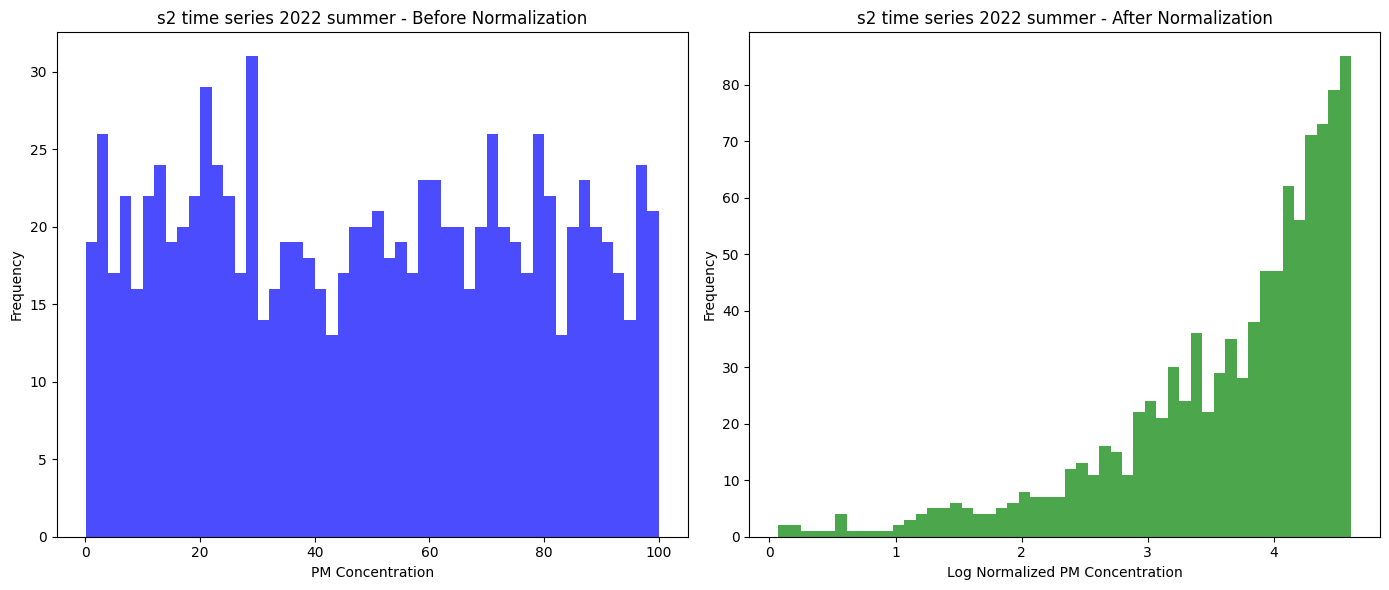

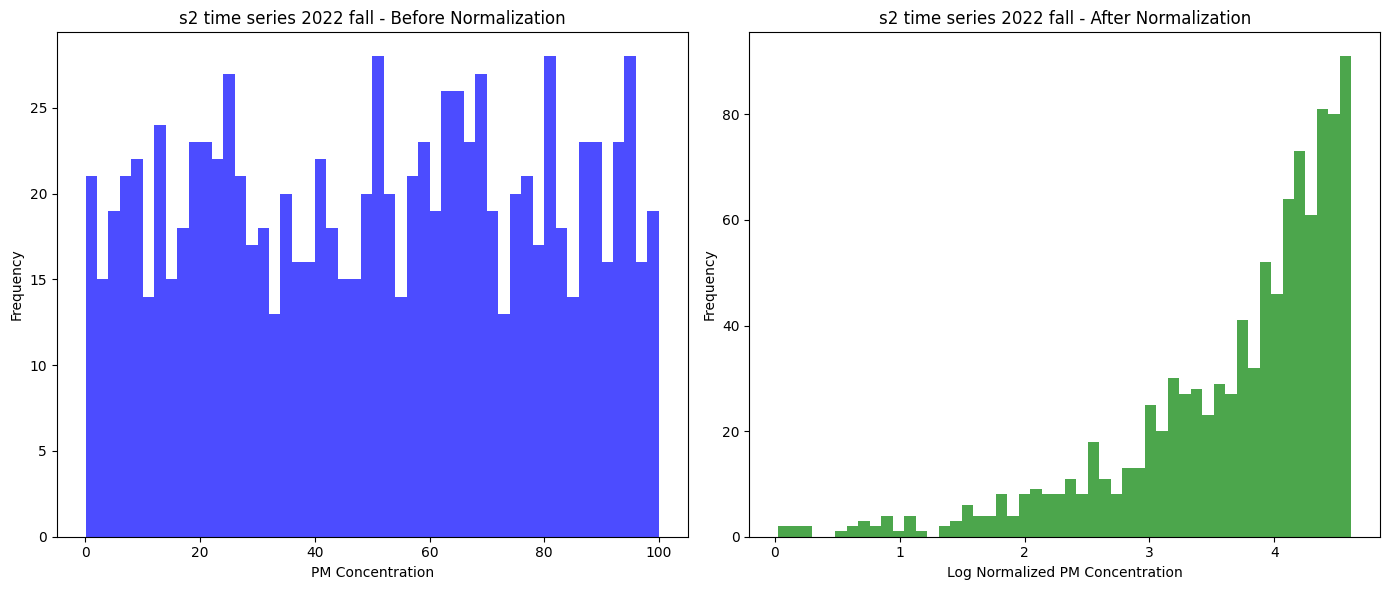

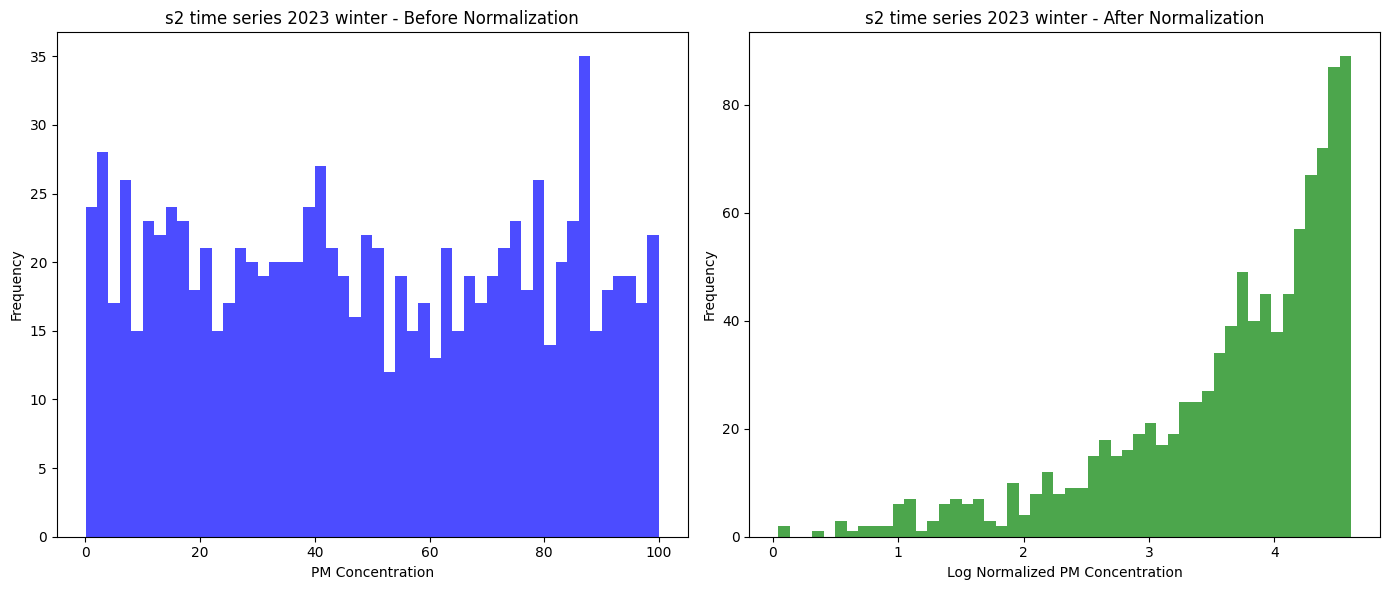

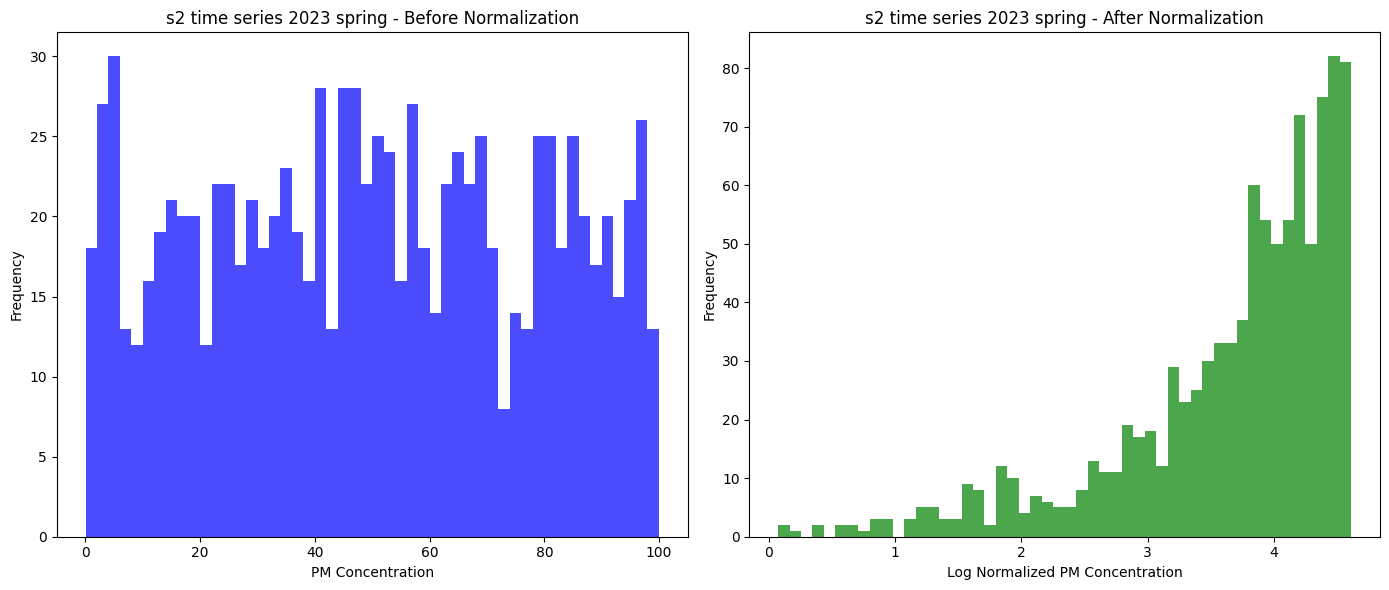

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def log_normalize(data):
    epsilon = 1e-6
    data = np.maximum(data, 0)  # Ensure all values are non-negative
    return np.log1p(data + epsilon)

def plot_distribution_before_after(data, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    ax[0].set_title(f'{title} - Before Normalization')
    ax[0].set_xlabel('PM Concentration')
    ax[0].set_ylabel('Frequency')

    log_normalized_data = log_normalize(data)
    ax[1].hist(log_normalized_data.flatten(), bins=50, color='green', alpha=0.7)
    ax[1].set_title(f'{title} - After Normalization')
    ax[1].set_xlabel('Log Normalized PM Concentration')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example data for visualization
seasonal_data_s2 = {
    's2_2022_summer': np.random.rand(1000, 1) * 100,  # Replace with actual data
    's2_2022_fall': np.random.rand(1000, 1) * 100,    # Replace with actual data
    's2_2023_winter': np.random.rand(1000, 1) * 100,  # Replace with actual data
    's2_2023_spring': np.random.rand(1000, 1) * 100   # Replace with actual data
}

# Define the season keys for s2 data
s2_season_keys = {
    's2_time_series_2022_summer': seasonal_data_s2['s2_2022_summer'],
    's2_time_series_2022_fall': seasonal_data_s2['s2_2022_fall'],
    's2_time_series_2023_winter': seasonal_data_s2['s2_2023_winter'],
    's2_time_series_2023_spring': seasonal_data_s2['s2_2023_spring'],
}

# Visualize distributions before and after normalization
for key, data in s2_season_keys.items():
    plot_distribution_before_after(data, key.replace("_", " "))


In [11]:
# Define the month keys for m1 data
m1_keys = {
    'm1_time_series_2022_06': m1_june22,
    'm1_time_series_2022_07': m1_july22,
    'm1_time_series_2022_08': m1_aug22,
    'm1_time_series_2022_09': m1_sept22,
    'm1_time_series_2022_10': m1_oct22,
    'm1_time_series_2022_11': m1_nov22,
    'm1_time_series_2022_12': m1_dec22,
    'm1_time_series_2023_01': m1_jan23,
    'm1_time_series_2023_02': m1_feb23,
    'm1_time_series_2023_03': m1_mar23,
    'm1_time_series_2023_04': m1_apr23,
    'm1_time_series_2023_05': m1_may23,
    'm1_time_series_2023_06': m1_june23,
}

# Loop through all months
for key, data in m1_keys.items():
    print(f'GP on {key.replace("_", " ")} log_normalized data 50% test and train on both sets')
    run_plt_gp(log_normalize(data), time_series_m1_dict[key], f'Gaussian Process on {key}', 0)
    run_plt_gp(log_normalize(data), time_series_m1_dict[key],f'Gaussian Process on {key}', 1)
    print(" ")


NameError: name 'm1_june22' is not defined